In [ ]:
"""
Country Classification Model using Logistic Regression

This code builds and evaluates a machine learning model to predict countries based on travel data.
It implements feature engineering, hyperparameter tuning, and model comparison to achieve high accuracy.

Author: Myat Ko
"""

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# -----------------------------------------------------------------------------
# DATA LOADING AND EXPLORATION
# -----------------------------------------------------------------------------

# Load the dataset
# The dataset contains travel information with features like arrivals, departures, and regional indicators
df = pd.read_csv("C:/Users/Myat Ko/Documents/GitHub/traveltrends/Classification/train_data_with_holidays.csv")

# Print dataset summary information
print(f"Dataset shape: {df.shape}")
print(f"Number of unique countries: {df['Country'].nunique()}")
print(f"Countries: {', '.join(sorted(df['Country'].unique()))}")

Dataset shape: (3672, 17)
Number of unique countries: 18
Countries: Europe, France, Germany, Hong Kong, Indonesia, Japan, Mainland China, Malaysia, Middle East, North America, North East Asia, Oceania, Philippines, South Asia, South East Asia, Thailand, United Kingdom, Vietnam


In [ ]:
# -----------------------------------------------------------------------------
# DATA PREPARATION
# -----------------------------------------------------------------------------

# Create the target variable (what we want to predict) - which country
y_country = df['Country']

# Create features - using relevant columns except Country
# These include temporal features, traffic metrics, and regional indicators
X = df[['Month', 'Year', 'Departures', 'Arrivals', 'Quarter', 'Years_Since_2000', 
        'Departures_Growth', 'Arrivals_Growth', 'Is_Holiday_Month',
        'Region_East Asia', 'Region_Europe', 'Region_Middle East', 
        'Region_North America', 'Region_Oceania', 'Region_South Asia', 
        'Region_South East Asia']]

# Split data into training (70%) and testing (30%) sets
# Using a fixed random seed (42) ensures reproducible results
X_train, X_test, y_train, y_test = train_test_split(
    X, y_country, test_size=0.3, random_state=42
)

# Scale features to have mean=0 and variance=1
# This is important for logistic regression to treat all features equally
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# -----------------------------------------------------------------------------
# FEATURE ENGINEERING - CREATE INTERACTION TERMS
# -----------------------------------------------------------------------------
# Feature interactions can capture relationships that single features cannot
# For example: how arrivals during holidays differ from non-holidays
# -----------------------------------------------------------------------------

print("\n=== FEATURE ENGINEERING ===")
print("Creating polynomial features and interactions...")

# Create polynomial features (interaction terms only)
# This creates new features that are products of the original features
# For example: Arrivals * Is_Holiday_Month, Departures * Region_Europe
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

# Get feature names for better interpretability
poly_feature_names = []
feature_names = X.columns
for i, feat in enumerate(poly.get_feature_names_out(feature_names)):
    if i < len(feature_names):  # Original features
        poly_feature_names.append(feat)
    else:  # Interaction terms
        poly_feature_names.append(feat)

print(f"Original features: {X_train_scaled.shape[1]}")
print(f"After adding interactions: {X_train_poly.shape[1]}")

In [ ]:
# -----------------------------------------------------------------------------
# FEATURE SELECTION USING RANDOM FOREST
# -----------------------------------------------------------------------------
# Not all features are equally important. Feature selection helps:
# 1. Identify the most predictive features
# 2. Potentially reduce model complexity and improve performance
# -----------------------------------------------------------------------------

print("\n=== FEATURE SELECTION ===")
print("Using Random Forest for feature importance...")

# Train a random forest to get feature importances
# Random Forest naturally ranks features by their predictive power
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

# Get and print feature importance
feature_importances = rf.feature_importances_
sorted_idx = np.argsort(feature_importances)[::-1]

# Print the top 10 most important features
print("Top 10 features by importance:")
for i in range(min(10, len(feature_names))):
    idx = sorted_idx[i]
    print(f"{feature_names[idx]}: {feature_importances[idx]:.4f}")

# Select top features using SelectFromModel
# This automatically selects features that are above the median importance
select_model = SelectFromModel(rf, threshold="median")
X_train_selected = select_model.fit_transform(X_train_scaled, y_train)
X_test_selected = select_model.transform(X_test_scaled)

print(f"Selected {X_train_selected.shape[1]} features out of {X_train_scaled.shape[1]}")

# Get and print the names of the selected features
selected_mask = select_model.get_support()
selected_features = [feature for feature, selected in zip(feature_names, selected_mask) if selected]
print("Selected features:", selected_features)

In [ ]:
# -----------------------------------------------------------------------------
# HYPERPARAMETER TUNING USING GRID SEARCH
# -----------------------------------------------------------------------------
# Default model parameters are rarely optimal for a specific problem
# Grid Search systematically tries different combinations to find the best
# -----------------------------------------------------------------------------

print("\n=== HYPERPARAMETER TUNING ===")

# Create a pipeline for model training and evaluation
# The pipeline ensures consistent preprocessing for all cross-validation folds
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Grid search parameters
# We test multiple values for regularization strength, solver algorithm, and class weighting
param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength (smaller values = stronger regularization)
    'classifier__solver': ['lbfgs', 'newton-cg', 'saga'],  # Algorithm to use in the optimization
    'classifier__class_weight': [None, 'balanced']  # Whether to adjust weights inversely proportional to class frequencies
}

# Stratified k-fold cross-validation
# Ensures each fold has the same proportion of each country as the full dataset
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform grid search
# This will train and evaluate models with all combinations of parameters
grid_search = GridSearchCV(
    pipe, param_grid, cv=cv, scoring='accuracy', verbose=1, n_jobs=-1
)

print("Performing grid search for optimal hyperparameters...")
grid_search.fit(X_train, y_train)

# Print best parameters
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.4f}".format(grid_search.best_score_))

# Store the best parameters for later use
best_params = grid_search.best_params_
best_C = best_params['classifier__C']
best_solver = best_params['classifier__solver']
best_class_weight = best_params['classifier__class_weight']

print("\n=== TRAINING FINAL MODEL ===")
print(f"C={best_C}, solver={best_solver}, class_weight={best_class_weight}")

In [ ]:
# -----------------------------------------------------------------------------
# MODEL COMPARISON
# -----------------------------------------------------------------------------
# Compare different model variations to find the best approach
# -----------------------------------------------------------------------------

# Define multiple model variations to compare
models = {
    "Base Logistic Regression": LogisticRegression(
        max_iter=1000, random_state=42, solver='lbfgs'
    ),
    "Tuned Logistic Regression": LogisticRegression(
        C=best_C, solver=best_solver, class_weight=best_class_weight,
        max_iter=1000, random_state=42
    ),
    "Logistic with Selected Features": LogisticRegression(
        C=best_C, solver=best_solver, class_weight=best_class_weight,
        max_iter=1000, random_state=42
    ),
    "Logistic with Interactions": LogisticRegression(
        C=best_C, solver=best_solver, class_weight=best_class_weight,
        max_iter=1000, random_state=42
    )
}

# Function to evaluate each model variation
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name="Classification Model"):
    """
    Trains and evaluates a classification model, focusing on problematic classes.
    
    Args:
        model: The classification model to evaluate
        X_train, X_test: Training and testing features
        y_train, y_test: Training and testing target values
        model_name: Name of the model for reporting
        
    Returns:
        accuracy: Overall model accuracy
        y_pred: Model predictions
        low_performing: List of classes with precision < 70%
    """
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Print summary
    print(f"\n===== {model_name} =====")
    print(f"Accuracy: {accuracy:.4f}")
    
    # Calculate detailed metrics
    report = classification_report(y_test, y_pred, output_dict=True)
    
    # Print class-wise accuracy for problem classes
    print("\nClass-wise precision for problematic classes:")
    low_performing = []
    for cls in report:
        if cls not in ['accuracy', 'macro avg', 'weighted avg']:
            precision = report[cls]['precision']
            if precision < 0.7:  # Focus on problematic classes (below 70% precision)
                print(f"{cls}: {precision:.4f}")
                low_performing.append(cls)
    
    return accuracy, y_pred, low_performing

# Define feature sets for each model variation
X_train_variations = {
    "Base Logistic Regression": X_train_scaled,
    "Tuned Logistic Regression": X_train_scaled,
    "Logistic with Selected Features": X_train_selected,
    "Logistic with Interactions": X_train_poly
}

X_test_variations = {
    "Base Logistic Regression": X_test_scaled,
    "Tuned Logistic Regression": X_test_scaled,
    "Logistic with Selected Features": X_test_selected,
    "Logistic with Interactions": X_test_poly
}

# Train and evaluate each model variation
print("\n=== MODEL COMPARISON ===")
results = {}
low_performing_classes = set()

for name, model in models.items():
    X_train_var = X_train_variations[name]
    X_test_var = X_test_variations[name]
    
    accuracy, y_pred, low_perf = evaluate_model(
        model, X_train_var, X_test_var, y_train, y_test, name
    )
    results[name] = accuracy
    low_performing_classes.update(low_perf)

# Print comparison of model accuracies
print("\n=== FINAL RESULTS ===")
for name, accuracy in sorted(results.items(), key=lambda x: x[1], reverse=True):
    print(f"{name}: {accuracy:.4f}")

# Identify classes that remain problematic across models
print("\nCommonly problematic classes:")
for cls in sorted(low_performing_classes):
    print(f"- {cls}")


In [ ]:
# -----------------------------------------------------------------------------
# VISUALIZING THE BEST MODEL
# -----------------------------------------------------------------------------
# Confusion matrix helps identify which countries are being confused with others
# -----------------------------------------------------------------------------

print("\n=== VISUALIZING BEST MODEL ===")
best_model_name = max(results, key=results.get)
print(f"Best model: {best_model_name} (Accuracy: {results[best_model_name]:.4f})")

# Retrain and evaluate best model for visualization
best_model = models[best_model_name]
X_train_best = X_train_variations[best_model_name]
X_test_best = X_test_variations[best_model_name]

best_model.fit(X_train_best, y_train)
y_pred_best = best_model.predict(X_test_best)

# Plot confusion matrix
plt.figure(figsize=(16, 12))
cm = confusion_matrix(y_test, y_pred_best)
classes = np.unique(y_test)
cm_df = pd.DataFrame(cm, index=classes, columns=classes)

# Create heatmap visualization of confusion matrix
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='d')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

Please check the file path and try again.

=== FEATURE ENGINEERING ===
Creating polynomial features and interactions...
Original features: 16
After adding interactions: 136

=== FEATURE SELECTION ===
Using Random Forest for feature importance...
Top 10 features by importance:
Departures: 0.2289
Arrivals: 0.2200
Region_South East Asia: 0.0580
Region_Europe: 0.0564
Region_East Asia: 0.0556
Departures_Growth: 0.0488
Region_South Asia: 0.0457
Region_Oceania: 0.0447
Arrivals_Growth: 0.0445
Region_North America: 0.0441
Selected 8 features out of 16
Selected features: ['Departures', 'Arrivals', 'Departures_Growth', 'Region_East Asia', 'Region_Europe', 'Region_Oceania', 'Region_South Asia', 'Region_South East Asia']

=== HYPERPARAMETER TUNING ===
Performing grid search for optimal hyperparameters...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'classifier__C': 100, 'classifier__class_weight': None, 'classifier__solver': 'newton-cg'}
Best cross-validation scor

c:\Users\Myat Ko\Documents\GitHub\traveltrends\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Myat Ko\Documents\GitHub\traveltrends\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



===== Tuned Logistic Regression =====
Accuracy: 0.8838

Class-wise precision for problematic classes:
Malaysia: 0.6000
Thailand: 0.6212


c:\Users\Myat Ko\Documents\GitHub\traveltrends\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



===== Logistic with Selected Features =====
Accuracy: 0.7278

Class-wise precision for problematic classes:
Hong Kong: 0.3538
Indonesia: 0.5439
Japan: 0.5217
Mainland China: 0.6122
Malaysia: 0.2368
North America: 0.5977
Philippines: 0.4203
Thailand: 0.4493


c:\Users\Myat Ko\Documents\GitHub\traveltrends\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



===== Logistic with Interactions =====
Accuracy: 0.9174

Class-wise precision for problematic classes:
Hong Kong: 0.6271

=== FINAL RESULTS ===
Logistic with Interactions: 0.9174
Tuned Logistic Regression: 0.8838
Base Logistic Regression: 0.8103
Logistic with Selected Features: 0.7278

Commonly problematic classes:
- France
- Hong Kong
- Indonesia
- Japan
- Mainland China
- Malaysia
- North America
- Philippines
- Thailand
- Vietnam

=== VISUALIZING BEST MODEL ===
Best model: Logistic with Interactions (Accuracy: 0.9174)


c:\Users\Myat Ko\Documents\GitHub\traveltrends\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


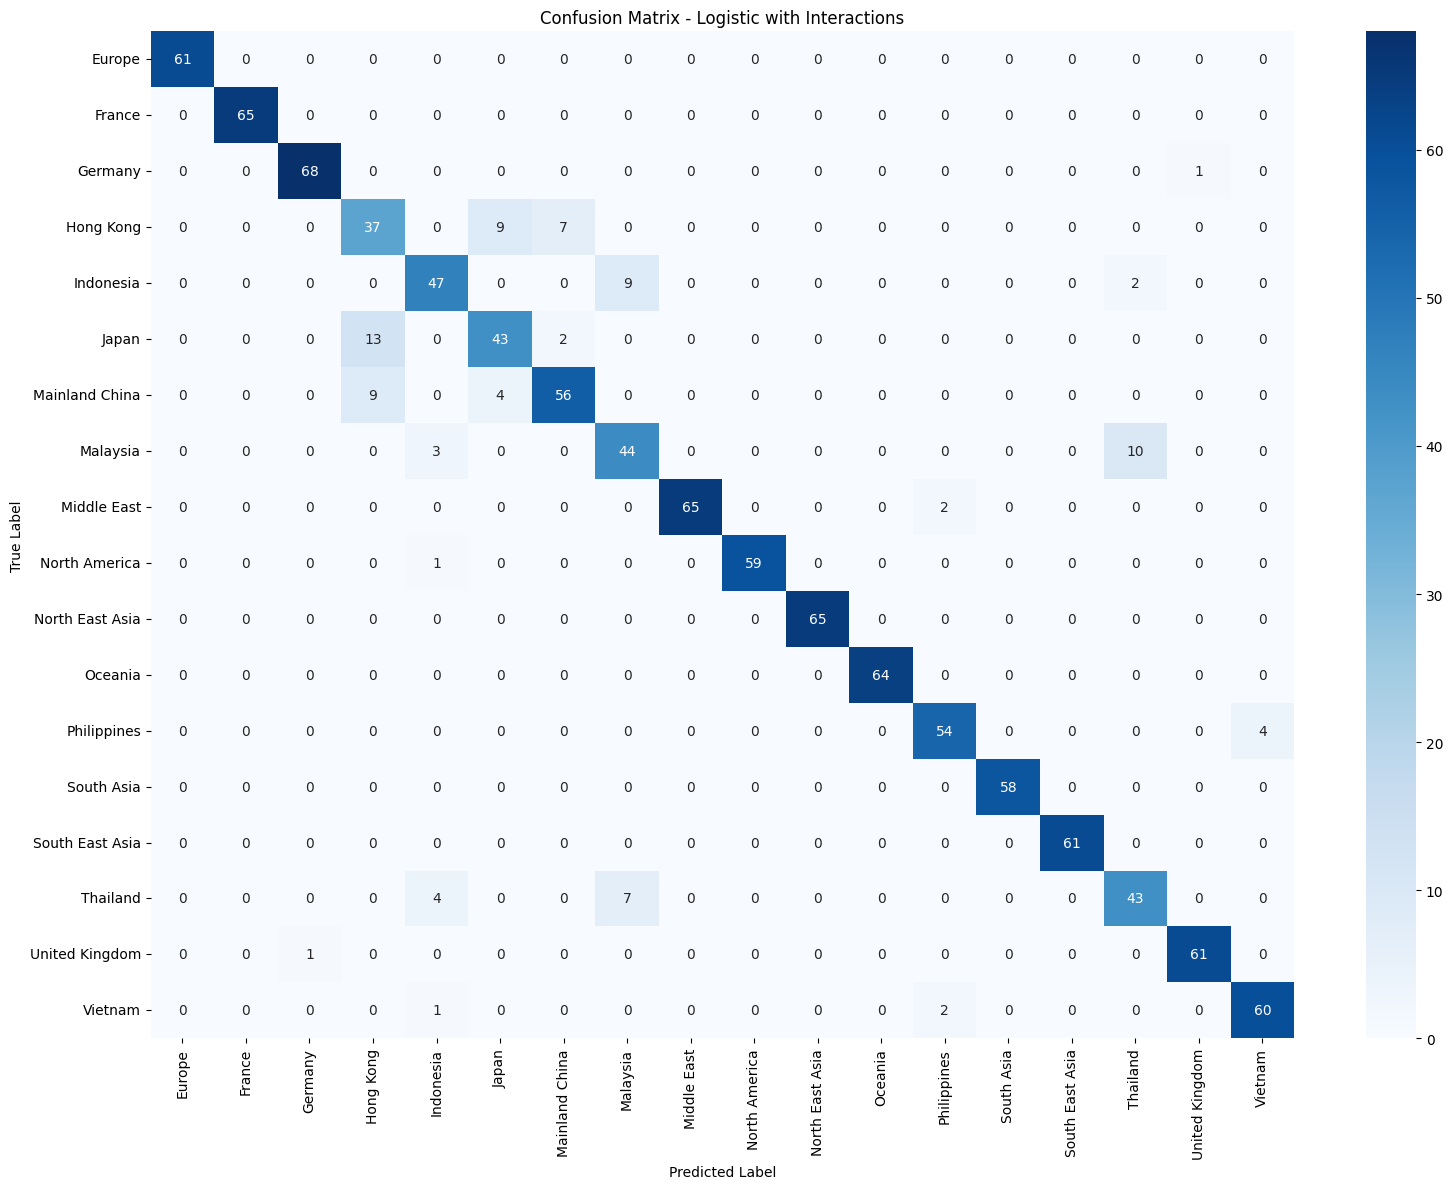

In [ ]:
#ALL IN 1
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
try:
    df = pd.read_csv("train_data_with_holidays.csv")
except:
    # Try alternative paths if the file isn't found
    try:
        df = pd.read_csv("Classification/train_data_with_holidays.csv")
    except:
        # To adjust this path based on current file structure
        print("Please check the file path and try again.")

# Create the multi-class target to predict which country
y_country = df['Country']

# Create features - using relevant columns except Country
X = df[['Month', 'Year', 'Departures', 'Arrivals', 'Quarter', 'Years_Since_2000', 
        'Departures_Growth', 'Arrivals_Growth', 'Is_Holiday_Month',
        'Region_East Asia', 'Region_Europe', 'Region_Middle East', 
        'Region_North America', 'Region_Oceania', 'Region_South Asia', 
        'Region_South East Asia']]

# Split data for model training and evaluation
X_train, X_test, y_train, y_test = train_test_split(
    X, y_country, test_size=0.3, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 1. Feature Engineering - Create interaction terms
print("\n=== FEATURE ENGINEERING ===")
print("Creating polynomial features and interactions...")

# Create polynomial features (including interaction terms)
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

# Get feature names for polynomials
poly_feature_names = []
feature_names = X.columns
for i, feat in enumerate(poly.get_feature_names_out(feature_names)):
    if i < len(feature_names):  # Original features
        poly_feature_names.append(feat)
    else:  # Interaction terms
        poly_feature_names.append(feat)

print(f"Original features: {X_train_scaled.shape[1]}")
print(f"After adding interactions: {X_train_poly.shape[1]}")

# 2. Feature Selection using Random Forest
print("\n=== FEATURE SELECTION ===")
print("Using Random Forest for feature importance...")

# Train a random forest to get feature importances
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

# Get feature importance
feature_importances = rf.feature_importances_
sorted_idx = np.argsort(feature_importances)[::-1]

# Print important features
print("Top 10 features by importance:")
for i in range(min(10, len(feature_names))):
    idx = sorted_idx[i]
    print(f"{feature_names[idx]}: {feature_importances[idx]:.4f}")

# Select top features using SelectFromModel
select_model = SelectFromModel(rf, threshold="median")
X_train_selected = select_model.fit_transform(X_train_scaled, y_train)
X_test_selected = select_model.transform(X_test_scaled)

print(f"Selected {X_train_selected.shape[1]} features out of {X_train_scaled.shape[1]}")

# Create masks for the selected features
selected_mask = select_model.get_support()
selected_features = [feature for feature, selected in zip(feature_names, selected_mask) if selected]
print("Selected features:", selected_features)

# 3. Cross-validation and Hyperparameter Tuning
print("\n=== HYPERPARAMETER TUNING ===")

# Create a pipeline for model training and evaluation with original features
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Grid search parameters
param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__solver': ['lbfgs', 'newton-cg', 'saga'],
    'classifier__class_weight': [None, 'balanced']
}

# Stratified k-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform grid search
grid_search = GridSearchCV(
    pipe, param_grid, cv=cv, scoring='accuracy', verbose=1, n_jobs=-1
)

print("Performing grid search for optimal hyperparameters...")
grid_search.fit(X_train, y_train)

# Print best parameters
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.4f}".format(grid_search.best_score_))

# Train final model with best parameters
best_params = grid_search.best_params_
best_C = best_params['classifier__C']
best_solver = best_params['classifier__solver']
best_class_weight = best_params['classifier__class_weight']

print("\n=== TRAINING FINAL MODEL ===")
print(f"C={best_C}, solver={best_solver}, class_weight={best_class_weight}")

# 4. Train multiple models for comparison
models = {
    "Base Logistic Regression": LogisticRegression(
        max_iter=1000, random_state=42, multi_class='multinomial', solver='lbfgs'
    ),
    "Tuned Logistic Regression": LogisticRegression(
        C=best_C, solver=best_solver, class_weight=best_class_weight,
        max_iter=1000, random_state=42, multi_class='multinomial'
    ),
    "Logistic with Selected Features": LogisticRegression(
        C=best_C, solver=best_solver, class_weight=best_class_weight,
        max_iter=1000, random_state=42, multi_class='multinomial'
    ),
    "Logistic with Interactions": LogisticRegression(
        C=best_C, solver=best_solver, class_weight=best_class_weight,
        max_iter=1000, random_state=42, multi_class='multinomial'
    )
}

# Evaluate classification model
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name="Classification Model"):
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Print summary
    print(f"\n===== {model_name} =====")
    print(f"Accuracy: {accuracy:.4f}")
    
    # Calculate detailed metrics
    report = classification_report(y_test, y_pred, output_dict=True)
    
    # Print class-wise accuracy for problem classes
    print("\nClass-wise precision for problematic classes:")
    low_performing = []
    for cls in report:
        if cls not in ['accuracy', 'macro avg', 'weighted avg']:
            precision = report[cls]['precision']
            if precision < 0.7:  # Focus on problematic classes
                print(f"{cls}: {precision:.4f}")
                low_performing.append(cls)
    
    return accuracy, y_pred, low_performing

# Train and evaluate each model
results = {}
X_train_variations = {
    "Base Logistic Regression": X_train_scaled,
    "Tuned Logistic Regression": X_train_scaled,
    "Logistic with Selected Features": X_train_selected,
    "Logistic with Interactions": X_train_poly
}

X_test_variations = {
    "Base Logistic Regression": X_test_scaled,
    "Tuned Logistic Regression": X_test_scaled,
    "Logistic with Selected Features": X_test_selected,
    "Logistic with Interactions": X_test_poly
}

print("\n=== MODEL COMPARISON ===")
low_performing_classes = set()

for name, model in models.items():
    X_train_var = X_train_variations[name]
    X_test_var = X_test_variations[name]
    
    accuracy, y_pred, low_perf = evaluate_model(
        model, X_train_var, X_test_var, y_train, y_test, name
    )
    results[name] = accuracy
    low_performing_classes.update(low_perf)

# Print comparison
print("\n=== FINAL RESULTS ===")
for name, accuracy in sorted(results.items(), key=lambda x: x[1], reverse=True):
    print(f"{name}: {accuracy:.4f}")

# Identify commonly problematic classes
print("\nCommonly problematic classes:")
for cls in sorted(low_performing_classes):
    print(f"- {cls}")

# 5. Visualization - Confusion Matrix for best model
print("\n=== VISUALIZING BEST MODEL ===")
best_model_name = max(results, key=results.get)
print(f"Best model: {best_model_name} (Accuracy: {results[best_model_name]:.4f})")

# Retrain and evaluate best model for visualizations
best_model = models[best_model_name]
X_train_best = X_train_variations[best_model_name]
X_test_best = X_test_variations[best_model_name]

best_model.fit(X_train_best, y_train)
y_pred_best = best_model.predict(X_test_best)

# Plot confusion matrix
plt.figure(figsize=(16, 12))
cm = confusion_matrix(y_test, y_pred_best)
classes = np.unique(y_test)
cm_df = pd.DataFrame(cm, index=classes, columns=classes)

# Plot heatmap
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='d')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()